In [64]:
# The workflow of this code consists of three parts:
# 1. Data Cleaning (the code was written in Jupiter notebooks and then incorporated into Google Colab)
# 2. Calculating Medians (more robust against outliers) and Distributions
# 3. Machine Learning Models
# Each step includes code for visualization.

In [143]:
# PART I: DATA CLEANING (converting data types, removing nulls & duplicates, create agg. values like profit, etc)
# Import Python Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#Import dependencies for Machine Models
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

In [66]:
# Please UPLOAD the "movie_metadata.csv" file from the Resources folder to the same directory level as this code in Google Colab.

# Load the uploaded Excel file.
file_path = 'movie_metadata.csv'
# Set variable as the origibnal data
data_origin = pd.read_csv(file_path)
# Create a copy of the original data to keep it intactin case of any bugs
data = data_origin.copy()
# Display the first few rows of the dataset to understand its structure
data.head()

,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


In [67]:
# Clean the 'movie_title' column by removing 'Â' and any additional whitespace at the end
data['movie_title'] = data['movie_title'].str.replace('Â', '', regex=True).str.strip()
# Change the order of the columns and drop

In [68]:
# Change column order starting with defining the new column order
# Drop columns 'movie_imdb_link' and 'aspect_ratio'.
new_column_order = [
    'movie_title', 'gross', 'budget',  # Main movie details
    'actor_1_name', 'actor_1_facebook_likes',  # Actor 1 details
    'actor_2_name', 'actor_2_facebook_likes',  # Actor 2 details
    'actor_3_name', 'actor_3_facebook_likes',  # Actor 3 details
    'director_name', 'director_facebook_likes',  # Director details
    'duration', 'title_year', 'num_critic_for_reviews', 'num_user_for_reviews',  # Movie-specific details
    'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',  # User and cast data
    'movie_facebook_likes',  # Add this column here
    'plot_keywords', 'genres', 'language', 'country', 'content_rating', 'imdb_score', 'color',  # Other features
]

# Reorder the DataFrame based on the new column order
data = data[new_column_order]

# Check the first three of our restructured data
print(data.head(3))

                                movie_title        gross       budget  \
0                                    Avatar  760505847.0  237000000.0   
1  Pirates of the Caribbean: At World's End  309404152.0  300000000.0   
2                                   Spectre  200074175.0  245000000.0   

      actor_1_name  actor_1_facebook_likes      actor_2_name  \
0      CCH Pounder                  1000.0  Joel David Moore   
1      Johnny Depp                 40000.0     Orlando Bloom   
2  Christoph Waltz                 11000.0      Rory Kinnear   

   actor_2_facebook_likes      actor_3_name  actor_3_facebook_likes  \
0                   936.0         Wes Studi                   855.0   
1                  5000.0    Jack Davenport                  1000.0   
2                   393.0  Stephanie Sigman                   161.0   

    director_name  ...  cast_total_facebook_likes  facenumber_in_poster  \
0   James Cameron  ...                       4834                   0.0   
1  Gore Verbins

In [69]:
# Make a copy of the data for debugging purposes
m_data = data.copy()
# Filter the data to include only rows where the 'country' column is equal to 'USA'
filtered_data = m_data[data['country'] == 'USA']
# We would like to limit the scope for the US only to remove biasis of foreign movies making less in the US may not be their primary target

In [70]:
# Fill missing values for string columns like 'director_name' with 'Unknown'
filtered_data.loc[:, ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']] = filtered_data.loc[:, ['director_name', 'actor_1_name', 'actor_2_name', 'actor_3_name']].fillna('Unknown')

# Replace 'Unrated' with 'Not rated' in the 'content_rating' column
filtered_data.loc[:, 'content_rating'] = filtered_data['content_rating'].replace('Unrated', 'Not rated')

# Drop rows with any other missing values to create a more accurate machine learning model
transformed_data = filtered_data.dropna()

In [71]:
# Get the number of rows in the DataFrame to verify data size and successful data type conversion for 'gross' and 'budget' columns
# Check if any other values need conversion
num_rows = transformed_data.shape[0]

# Get the data types of each column
data_types = transformed_data.dtypes

# Display the results
print(f"Number of the remaining rows: {num_rows}")
print("\nData types of each column:")
print(data_types)

Number of the remaining rows: 3026

Data types of each column:
movie_title                   object
gross                        float64
budget                       float64
actor_1_name                  object
actor_1_facebook_likes       float64
actor_2_name                  object
actor_2_facebook_likes       float64
actor_3_name                  object
actor_3_facebook_likes       float64
director_name                 object
director_facebook_likes      float64
duration                     float64
title_year                   float64
num_critic_for_reviews       float64
num_user_for_reviews         float64
num_voted_users                int64
cast_total_facebook_likes      int64
facenumber_in_poster         float64
movie_facebook_likes           int64
plot_keywords                 object
genres                        object
language                      object
country                       object
content_rating                object
imdb_score                   float64
color       

In [72]:
# Convert 'budget' and 'gross' columns to integers. Rpounded to the whole numbers
data['budget'] = pd.to_numeric(data['budget'], errors='coerce').fillna(0).round(0).astype(int)
data['gross'] = pd.to_numeric(data['gross'], errors='coerce').fillna(0).round(0).astype(int)

# Use .loc to modify the data types in other columns without triggering Warning messages
transformed_data.loc[:, 'actor_1_facebook_likes'] = pd.to_numeric(transformed_data['actor_1_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'actor_2_facebook_likes'] = pd.to_numeric(transformed_data['actor_2_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'actor_3_facebook_likes'] = pd.to_numeric(transformed_data['actor_3_facebook_likes'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'num_critic_for_reviews'] = pd.to_numeric(transformed_data['num_critic_for_reviews'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'num_user_for_reviews'] = pd.to_numeric(transformed_data['num_user_for_reviews'], errors='coerce').fillna(0).round(0).astype(int)
transformed_data.loc[:, 'facenumber_in_poster'] = pd.to_numeric(transformed_data['facenumber_in_poster'], errors='coerce').fillna(0).round(0).astype(int)

# Convert the 'title_year' column to integer format, ensuring proper handling of missing values
transformed_data['title_year'] = pd.to_numeric(transformed_data['title_year'], errors='coerce').astype('Int64')

# Display the first 5 rows of the data
transformed_data.head()


<ipython-input-72-9feafec98907>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['budget'] = pd.to_numeric(data['budget'], errors='coerce').fillna(0).round(0).astype(int)
<ipython-input-72-9feafec98907>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['gross'] = pd.to_numeric(data['gross'], errors='coerce').fillna(0).round(0).astype(int)
<ipython-input-72-9feafec98907>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

,movie_title,gross,budget,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,director_name,...,cast_total_facebook_likes,facenumber_in_poster,movie_facebook_likes,plot_keywords,genres,language,country,content_rating,imdb_score,color
0,Avatar,760505847.0,237000000.0,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,James Cameron,...,4834,0.0,33000,avatar|future|marine|native|paraplegic,Action|Adventure|Fantasy|Sci-Fi,English,USA,PG-13,7.9,Color
1,Pirates of the Caribbean: At World's End,309404152.0,300000000.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,Gore Verbinski,...,48350,0.0,0,goddess|marriage ceremony|marriage proposal|pi...,Action|Adventure|Fantasy,English,USA,PG-13,7.1,Color
3,The Dark Knight Rises,448130642.0,250000000.0,Tom Hardy,27000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,23000.0,Christopher Nolan,...,106759,0.0,164000,deception|imprisonment|lawlessness|police offi...,Action|Thriller,English,USA,PG-13,8.5,Color
5,John Carter,73058679.0,263700000.0,Daryl Sabara,640.0,Samantha Morton,632.0,Polly Walker,530.0,Andrew Stanton,...,1873,1.0,24000,alien|american civil war|male nipple|mars|prin...,Action|Adventure|Sci-Fi,English,USA,PG-13,6.6,Color
6,Spider-Man 3,336530303.0,258000000.0,J.K. Simmons,24000.0,James Franco,11000.0,Kirsten Dunst,4000.0,Sam Raimi,...,46055,0.0,0,sandman|spider man|symbiote|venom|villain,Action|Adventure|Romance,English,USA,PG-13,6.2,Color


In [73]:
# Remove rows where 'movie_title' has duplicates (keep the first occurrence and drop others)
cleaned_data = transformed_data.drop_duplicates(subset=['movie_title'], keep='first')
# That removes movies wiht identical titles and avoid confusion in our machine learning models if movies names were used more than once.

In [74]:
# Show two first rows and the data size
cleaned_data.shape
print(cleaned_data.head(2))

                                movie_title        gross       budget  \
0                                    Avatar  760505847.0  237000000.0   
1  Pirates of the Caribbean: At World's End  309404152.0  300000000.0   

  actor_1_name  actor_1_facebook_likes      actor_2_name  \
0  CCH Pounder                  1000.0  Joel David Moore   
1  Johnny Depp                 40000.0     Orlando Bloom   

   actor_2_facebook_likes    actor_3_name  actor_3_facebook_likes  \
0                   936.0       Wes Studi                   855.0   
1                  5000.0  Jack Davenport                  1000.0   

    director_name  ...  cast_total_facebook_likes  facenumber_in_poster  \
0   James Cameron  ...                       4834                   0.0   
1  Gore Verbinski  ...                      48350                   0.0   

   movie_facebook_likes                                      plot_keywords  \
0                 33000             avatar|future|marine|native|paraplegic   
1        

In [75]:
# Make a copy of 'cleaned_data' for debugging purposes
# for debugging purposes
cleaned_data = cleaned_data.copy()

# Create a new column for profit using .loc
cleaned_data.loc[:, 'profit'] = cleaned_data['gross'] - cleaned_data['budget']


In [76]:
# Ensure that the 'profit' column is numeric, and convert if necessary to integers
cleaned_data['profit'] = pd.to_numeric(cleaned_data['profit'], errors='coerce').fillna(0).astype(int)
# Show cleaned data size
cleaned_data.shape

(2945, 27)

In [77]:
# Sorting the data by profit to find the top and bottom 5 movies
top_5_profitable_movies = cleaned_data.sort_values(by='profit', ascending=False).head(5)
bottom_5_profitable_movies = cleaned_data.sort_values(by='profit', ascending=True).head(5)

In [78]:
# Save files to the default Google Colab Directory
cleaned_data.to_csv('/content/cleaned_data.csv', index=False)
top_5_profitable_movies.to_csv('/content/top_5_profitable_movies.csv', index=False)
bottom_5_profitable_movies.to_csv('/content/bottom_5_profitable_movies.csv', index=False)

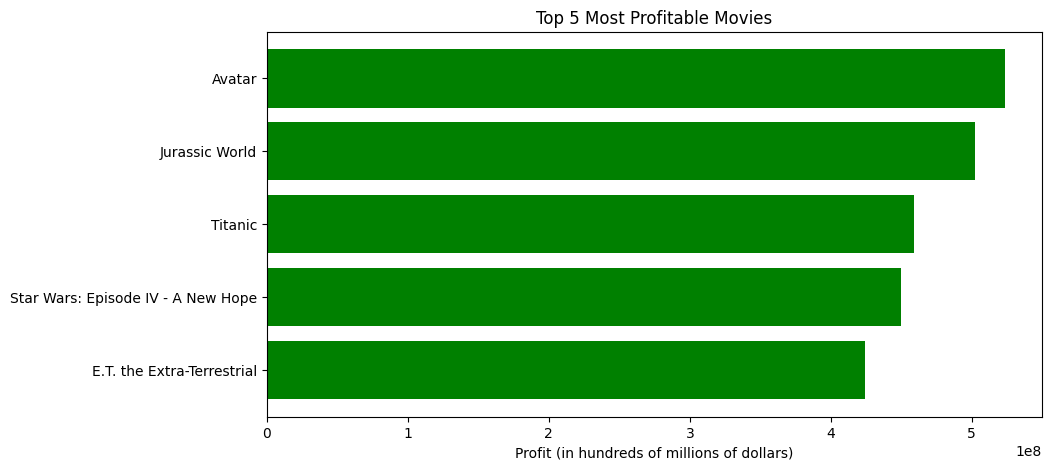

In [79]:
# Visualization of the 5 most profitable movies
plt.figure(figsize=(10, 5))
plt.barh(top_5_profitable_movies['movie_title'], top_5_profitable_movies['profit'], color='green')  # Correct the order
plt.xlabel('Profit (in hundreds of millions of dollars)')  # title of the axis label
plt.title('Top 5 Most Profitable Movies') #plot title
plt.gca().invert_yaxis()  # Invert to show sorted by the highest profit
plt.show()

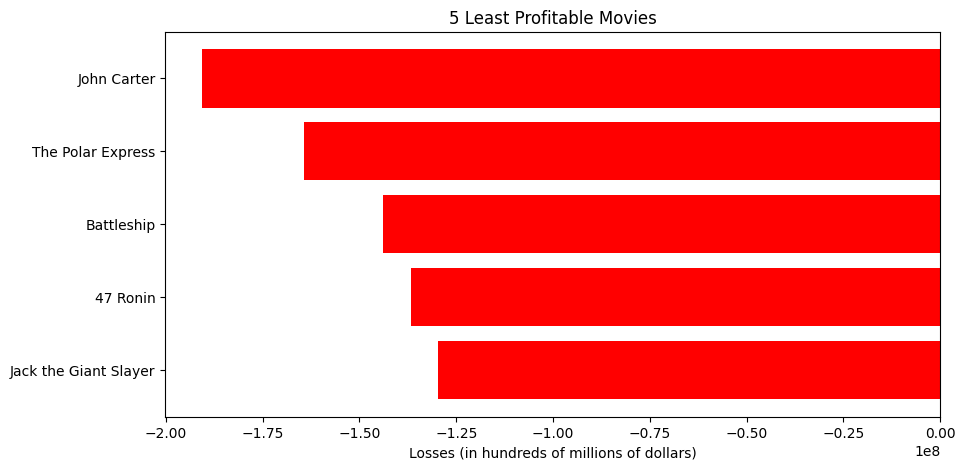

In [80]:
# Visualization: Plot the 5 least profitable movies
plt.figure(figsize=(10, 5))
plt.barh(bottom_5_profitable_movies['movie_title'], bottom_5_profitable_movies['profit'], color='red')
plt.xlabel('Losses (in hundreds of millions of dollars)')
plt.title('5 Least Profitable Movies')
plt.gca().invert_yaxis()  # Invert to show the lowest at the top
plt.show()

In [81]:
# Display the top 5 most profitable and 5 least profitable movies
print(top_5_profitable_movies[['movie_title', 'profit', 'gross', 'budget', 'director_name', 'actor_1_name', 'genres', 'country', 'movie_facebook_likes']])
print(bottom_5_profitable_movies[['movie_title', 'profit', 'gross', 'director_name', 'actor_1_name', 'genres', 'country', 'movie_facebook_likes']])

                             movie_title     profit        gross       budget  \
0                                 Avatar  523505847  760505847.0  237000000.0   
29                        Jurassic World  502177271  652177271.0  150000000.0   
26                               Titanic  458672302  658672302.0  200000000.0   
3024  Star Wars: Episode IV - A New Hope  449935665  460935665.0   11000000.0   
3080          E.T. the Extra-Terrestrial  424449459  434949459.0   10500000.0   

         director_name         actor_1_name                            genres  \
0        James Cameron          CCH Pounder   Action|Adventure|Fantasy|Sci-Fi   
29     Colin Trevorrow  Bryce Dallas Howard  Action|Adventure|Sci-Fi|Thriller   
26       James Cameron    Leonardo DiCaprio                     Drama|Romance   
3024      George Lucas        Harrison Ford   Action|Adventure|Fantasy|Sci-Fi   
3080  Steven Spielberg         Henry Thomas                     Family|Sci-Fi   

     country  movie_facebo

In [82]:
# PART II: CALCULATING AVERAGES AND DISTRIBUTIONS

In [83]:
# PART III: MACHINE LEARNING MODELS USING CLEAN DATA using Google Colab
# Linear Regression, Random Forest, Neuron Network models are used in this part

In [84]:
# Install Spark and Java
import os
# Set Environment Variables for Spark
spark_version = 'spark-3.4.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://archive.apache.org/dist/spark/spark-3.4.0/spark-3.4.0-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Java  and Spark Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Initialize PySpark
import findspark
findspark.init()

# Import PySpark DataFrame functions (round, col, sum etc.) with shorter alias
from pyspark.sql import functions as F

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Ign:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy Release
Hit:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Fetched 261 kB in 1s (193 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not s

In [85]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").config("spark.driver.memory", "2g").getOrCreate()

In [86]:
# Load the 'cleaned_data.csv' file from the Colab default content directory
cleaned_data = pd.read_csv('/content/cleaned_data.csv')

# Create a copy of the data to keep the original data intact in case of any errors
movie_data = cleaned_data.copy()
# Display the first 5 rows of the loaded data
movie_data.head()


,movie_title,gross,budget,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,director_name,...,facenumber_in_poster,movie_facebook_likes,plot_keywords,genres,language,country,content_rating,imdb_score,color,profit
0,Avatar,760505847.0,237000000.0,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,James Cameron,...,0.0,33000,avatar|future|marine|native|paraplegic,Action|Adventure|Fantasy|Sci-Fi,English,USA,PG-13,7.9,Color,523505847
1,Pirates of the Caribbean: At World's End,309404152.0,300000000.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,Gore Verbinski,...,0.0,0,goddess|marriage ceremony|marriage proposal|pi...,Action|Adventure|Fantasy,English,USA,PG-13,7.1,Color,9404152
2,The Dark Knight Rises,448130642.0,250000000.0,Tom Hardy,27000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,23000.0,Christopher Nolan,...,0.0,164000,deception|imprisonment|lawlessness|police offi...,Action|Thriller,English,USA,PG-13,8.5,Color,198130642
3,John Carter,73058679.0,263700000.0,Daryl Sabara,640.0,Samantha Morton,632.0,Polly Walker,530.0,Andrew Stanton,...,1.0,24000,alien|american civil war|male nipple|mars|prin...,Action|Adventure|Sci-Fi,English,USA,PG-13,6.6,Color,-190641321
4,Spider-Man 3,336530303.0,258000000.0,J.K. Simmons,24000.0,James Franco,11000.0,Kirsten Dunst,4000.0,Sam Raimi,...,0.0,0,sandman|spider man|symbiote|venom|villain,Action|Adventure|Romance,English,USA,PG-13,6.2,Color,78530303


In [87]:
# Get the number of rows in the date (to verify the data size)
num_rows = movie_data.shape[0]
# Print the result
print(f"Number of rows in the dataset: {num_rows}")

Number of rows in the dataset: 2945


In [88]:
# Verify success of data clean up: Check for missing values in the 'updated_data' DataFrame
missing_values = movie_data.isnull().sum()

# Display the result
print(missing_values)

movie_title                  0
gross                        0
budget                       0
actor_1_name                 0
actor_1_facebook_likes       0
actor_2_name                 0
actor_2_facebook_likes       0
actor_3_name                 0
actor_3_facebook_likes       0
director_name                0
director_facebook_likes      0
duration                     0
title_year                   0
num_critic_for_reviews       0
num_user_for_reviews         0
num_voted_users              0
cast_total_facebook_likes    0
facenumber_in_poster         0
movie_facebook_likes         0
plot_keywords                0
genres                       0
language                     0
country                      0
content_rating               0
imdb_score                   0
color                        0
profit                       0
dtype: int64


In [89]:
# The outlook above shows that the data no longer has any missing values.

In [90]:
# Further look at our data: Determine the number of unique values in each column
# to explore the possibility of binning rare values in nearon network models
unique_values = movie_data.nunique()
print(unique_values)

movie_title                  2945
gross                        2934
budget                        296
actor_1_name                 1153
actor_1_facebook_likes        596
actor_2_name                 1784
actor_2_facebook_likes        789
actor_3_name                 2121
actor_3_facebook_likes        851
director_name                1386
director_facebook_likes       362
duration                      140
title_year                     68
num_critic_for_reviews        503
num_user_for_reviews          869
num_voted_users              2921
cast_total_facebook_likes    2688
facenumber_in_poster           19
movie_facebook_likes          578
plot_keywords                2945
genres                        647
language                        9
country                         1
content_rating                 11
imdb_score                     74
color                           2
profit                       2939
dtype: int64


In [91]:
# Check the distribution of values in the 'gross' and 'budget' columns
# to explore the possibility of binning rare values (in nearon network models)
gross_type_counts = movie_data['gross'].value_counts()
budget_type_counts = movie_data['budget'].value_counts()
# Display the results
print(gross_type_counts)
print(budget_type_counts)


gross
8000000.0      3
25000000.0     2
69800000.0     2
141600000.0    2
36000000.0     2
              ..
94125426.0     1
95001343.0     1
81292135.0     1
86208010.0     1
85222.0        1
Name: count, Length: 2934, dtype: int64
budget
20000000.0    128
40000000.0    113
30000000.0    110
25000000.0     99
15000000.0     94
             ... 
8700000.0       1
16800000.0      1
16400000.0      1
17700000.0      1
1100.0          1
Name: count, Length: 296, dtype: int64


In [92]:
# Convert the Pandas DataFrame to a PySpark DataFrame
spark_movie_data = spark.createDataFrame(movie_data)

# Create a temporary view of the PySpark DataFrame
spark_movie_data.createOrReplaceTempView('movies')

# Get the data types of the columns for the PySpark DataFrame
spark_movie_data.printSchema()

# Run SQL queries on the DataFrame, use spark.sql
spark.sql("SELECT * FROM movies LIMIT 3").show()

root
 |-- movie_title: string (nullable = true)
 |-- gross: double (nullable = true)
 |-- budget: double (nullable = true)
 |-- actor_1_name: string (nullable = true)
 |-- actor_1_facebook_likes: double (nullable = true)
 |-- actor_2_name: string (nullable = true)
 |-- actor_2_facebook_likes: double (nullable = true)
 |-- actor_3_name: string (nullable = true)
 |-- actor_3_facebook_likes: double (nullable = true)
 |-- director_name: string (nullable = true)
 |-- director_facebook_likes: double (nullable = true)
 |-- duration: double (nullable = true)
 |-- title_year: long (nullable = true)
 |-- num_critic_for_reviews: double (nullable = true)
 |-- num_user_for_reviews: double (nullable = true)
 |-- num_voted_users: long (nullable = true)
 |-- cast_total_facebook_likes: long (nullable = true)
 |-- facenumber_in_poster: double (nullable = true)
 |-- movie_facebook_likes: long (nullable = true)
 |-- plot_keywords: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- languag

In [93]:
# Convert the 'duration', 'gross', 'budget' columns from double to integer
# Convert 'title_year' to integer format (for machine learning models)
spark_movie_data = spark_movie_data \
    .withColumn("duration", F.col("duration").cast("int")) \
    .withColumn("gross", F.col("gross").cast("int")) \
    .withColumn("budget", F.col("budget").cast("int")) \
    .withColumn("title_year", F.col("title_year").cast("int"))

# Verify the schema after conversion
spark_movie_data.printSchema()

# Run a SQL query to verify the changes
spark_movie_data.createOrReplaceTempView('movies')
spark.sql("SELECT duration, gross, budget, title_year FROM movies LIMIT 3").show()

root
 |-- movie_title: string (nullable = true)
 |-- gross: integer (nullable = true)
 |-- budget: integer (nullable = true)
 |-- actor_1_name: string (nullable = true)
 |-- actor_1_facebook_likes: double (nullable = true)
 |-- actor_2_name: string (nullable = true)
 |-- actor_2_facebook_likes: double (nullable = true)
 |-- actor_3_name: string (nullable = true)
 |-- actor_3_facebook_likes: double (nullable = true)
 |-- director_name: string (nullable = true)
 |-- director_facebook_likes: double (nullable = true)
 |-- duration: integer (nullable = true)
 |-- title_year: integer (nullable = true)
 |-- num_critic_for_reviews: double (nullable = true)
 |-- num_user_for_reviews: double (nullable = true)
 |-- num_voted_users: long (nullable = true)
 |-- cast_total_facebook_likes: long (nullable = true)
 |-- facenumber_in_poster: double (nullable = true)
 |-- movie_facebook_likes: long (nullable = true)
 |-- plot_keywords: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- l

In [109]:
# STEP 3.1: LINEAR REGRESSION
# For Linear Regression Models StandardScaler seems to be the better choice:
# it centers the data around zero and can handle varying scales more effectively.
# MinMaxScaler may compress the majority of your data into a small range, which can negatively impact the performance of linear regression

In [95]:
# Create a copy of the data
movies_us = movie_data.copy()
# Drop 'profit' column as a highly correlated aggregation value
movies_us = movies_us.drop(['profit'], axis=1)

In [96]:
# List of numerical features to be scaled
numerical_features = ['gross', 'budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                      'actor_3_facebook_likes', 'director_facebook_likes', 'duration',
                      'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
                      'cast_total_facebook_likes', 'movie_facebook_likes']
# Set StandardScaler as the best scaler option for Linear regression model
scaler = StandardScaler()
# Scale only the numerical columns
movies_us[numerical_features] = scaler.fit_transform(movies_us[numerical_features])

In [97]:
# Set features for Multiple Linear Regression
features = ['budget', 'duration', 'num_critic_for_reviews', 'num_user_for_reviews',
            'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes',
            'director_facebook_likes', 'num_voted_users', 'cast_total_facebook_likes',
            'movie_facebook_likes']
X = movies_us[features]  # Independent variables
y = movies_us['gross']   # Dependent variable

In [98]:
# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Thrain the Linear regression Model
model = LinearRegression()
model.fit(X_train, y_train)
# Make Predictions
y_pred = model.predict(X_test)



R-squared: 0.5706539556836718
Mean Squared Error: 0.42357315432805215


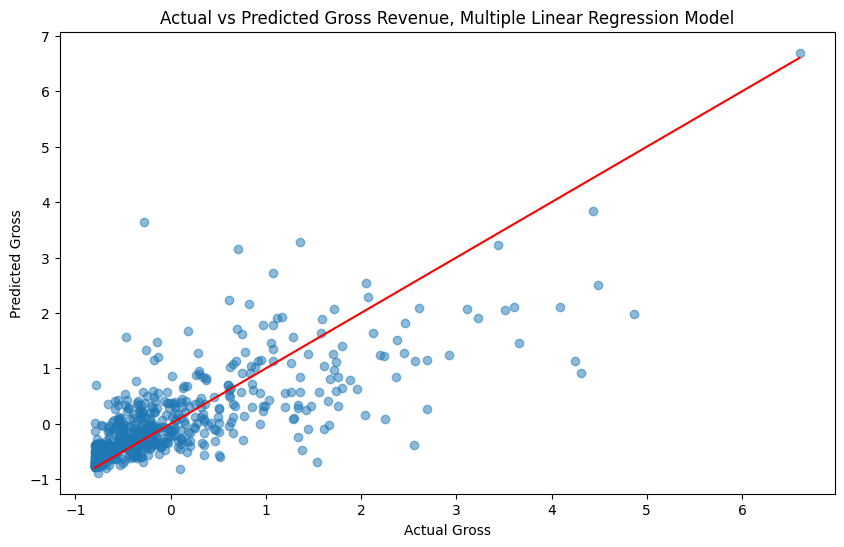

In [99]:
# Assess Multiple Linear Regression Model Accuracy
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')

# Create a Plot Showing Actual vs Predicted Gross Revenue
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Perfect fit line
plt.title('Actual vs Predicted Gross Revenue, Multiple Linear Regression Model')
plt.xlabel('Actual Gross')
plt.ylabel('Predicted Gross')
plt.show()

In [100]:
# The model explains about 57% of the changes in movie revenue based on the factors included, showing it has a decent fit, but 43% remains unexplained, suggesting other influences.
# The error rate (0.4236) shows how close the predictions are to actual values, but we need to compare it with other models to see how reliable it really is

In [101]:
# The accuracy rate for Multi Linear Regression is not the best
# This part of the code is aim to create Liner Regression model based on budget-gross correlation
# To verify if that increases predioction accuracy
movies_lin = movie_data.copy()

R-squared: 0.36543303277622263
Mean Squared Error: 0.6260347230341049


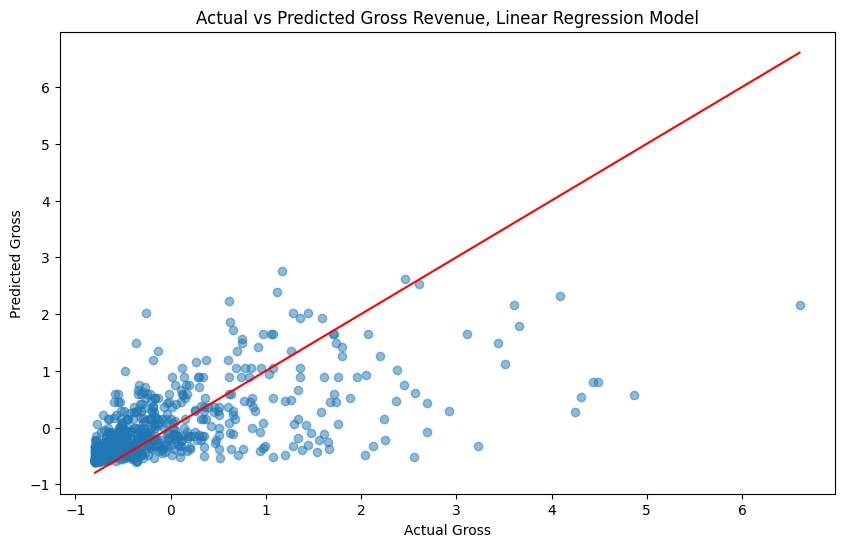

In [102]:
# List of numerical features to be scaled
numerical_features = ['gross', 'budget']

# Initialize the StandardScaler
scaler = StandardScaler()

# Scale only the numerical columns
movies_lin[numerical_features] = scaler.fit_transform(movies_lin[numerical_features])

# Set the feature for Simple Linear Regression (e.g., 'budget')
X = movies_lin[['budget']]  # Independent variable

# Dependent variable
y = movies_lin['gross']

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

# Make Predictions
y_pred = model.predict(X_test)

# Assess Model Accuracy
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f'R-squared: {r2}')
print(f'Mean Squared Error: {mse}')

# Create a Plot Showing Actual vs Predicted Gross Revenue
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Perfect fit line
plt.title('Actual vs Predicted Gross Revenue, Linear Regression Model')
plt.xlabel('Actual Gross')
plt.ylabel('Predicted Gross')
plt.show()

In [103]:
# Summary of the linear regression models:
# The multiple linear regression model is better because it has a higher R-squared value (explains more variance) and a lower MSE (higher accuracy).
# This indicates that using multiple features improves the model's ability to predict gross compared to using a single feature (budget) alone.

In [104]:
# STEP 3.2 NEURON METWORKS MODEL:

# Remove 'profit' column from our data
movies_ml = movie_data.drop('profit', axis=1)
movies_ml.head(3)

,movie_title,gross,budget,actor_1_name,actor_1_facebook_likes,actor_2_name,actor_2_facebook_likes,actor_3_name,actor_3_facebook_likes,director_name,...,cast_total_facebook_likes,facenumber_in_poster,movie_facebook_likes,plot_keywords,genres,language,country,content_rating,imdb_score,color
0,Avatar,760505847.0,237000000.0,CCH Pounder,1000.0,Joel David Moore,936.0,Wes Studi,855.0,James Cameron,...,4834,0.0,33000,avatar|future|marine|native|paraplegic,Action|Adventure|Fantasy|Sci-Fi,English,USA,PG-13,7.9,Color
1,Pirates of the Caribbean: At World's End,309404152.0,300000000.0,Johnny Depp,40000.0,Orlando Bloom,5000.0,Jack Davenport,1000.0,Gore Verbinski,...,48350,0.0,0,goddess|marriage ceremony|marriage proposal|pi...,Action|Adventure|Fantasy,English,USA,PG-13,7.1,Color
2,The Dark Knight Rises,448130642.0,250000000.0,Tom Hardy,27000.0,Christian Bale,23000.0,Joseph Gordon-Levitt,23000.0,Christopher Nolan,...,106759,0.0,164000,deception|imprisonment|lawlessness|police offi...,Action|Thriller,English,USA,PG-13,8.5,Color


In [106]:
# Encode categorical variables and scale numeric features
numeric_features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes',
                    'director_facebook_likes', 'duration', 'num_critic_for_reviews', 'num_user_for_reviews',
                    'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster', 'movie_facebook_likes',
                    'imdb_score']

categorical_features = ['genres', 'language', 'country', 'content_rating']

# Pipeline for numeric features
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())  # tested model betwwen StandardScaler and StandardScaler
])

# StandardScaler showed below average accuracy rates:
# R-squared Score: 0.429562678990826
# Mean Absolute Error: 35834051.32405958
# Mean Squared Error: 2923025304109841.0
# MinMax Scaler showed even loer accuracy rates:
# R-squared Score: 0.03477490620253032
# Mean Absolute Error: 44196614.22580645
# Mean Squared Error: 4945990154256447.0

# OneHotEncode categorical features
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column transformer to apply transformations to respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Splitting the data into features (X) and target (y)
X = movies_ml.drop(['gross', 'movie_title'], axis=1)
y = movies_ml['gross']

# Apply preprocessing and split the data
X_processed = preprocessor.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Build the neural network model
model = Sequential([
    Dense(64, input_dim=X_train.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32)

# Evaluate the model
y_pred = model.predict(X_test).flatten()
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f'R-squared Score: {r2}')
print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - loss: 8632803197452288.0000 - mean_absolute_error: 57558536.0000 - val_loss: 8537484451381248.0000 - val_mean_absolute_error: 58423480.0000
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8451287678976000.0000 - mean_absolute_error: 58373128.0000 - val_loss: 8537450091642880.0000 - val_mean_absolute_error: 58423284.0000
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 8457128297627648.0000 - mean_absolute_error: 55530048.0000 - val_loss: 8537251449405440.0000 - val_mean_absolute_error: 58422256.0000
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 8581931994185728.0000 - mean_absolute_error: 57932220.0000 - val_loss: 8536634584727552.0000 - val_mean_absolute_error: 58419100.0000
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 7426807519248384.0000 - mean_absolute_error: 55439472.0000 - val_loss: 8535131883044864.0000 - val_mean_absolute_error: 58411580.0000
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 

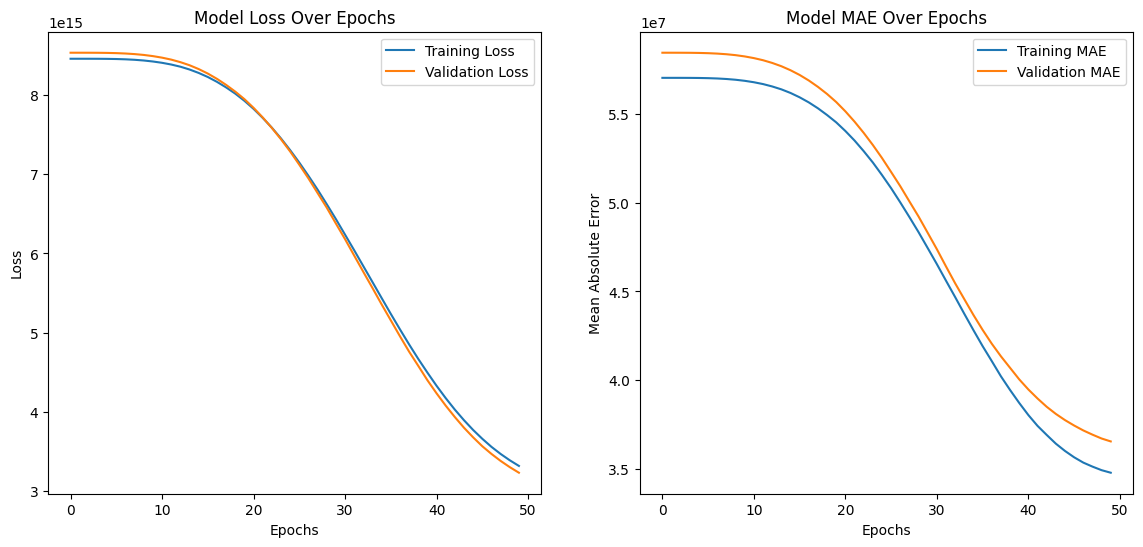

In [107]:
# Plotting model accuracy and loss over epochs
plt.figure(figsize=(14, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss Over Epochs')
plt.legend()

# Mean Absolute Error plot
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.title('Model MAE Over Epochs')
plt.legend()

plt.show()

In [ ]:
# The Neuron Network model showed low accuracy rates comparing to Multi-Linear Regression

In [111]:
# STEP 3.3 Running RANDOM FOREST MODEL to test its' accuracy
# This model only accounts numerical values
# Remove 'profit' column from our data
movies_mm = movie_data.drop('profit', axis=1)

In [113]:
# Selecting relevant nemerical features and target
features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
            'actor_3_facebook_likes', 'director_facebook_likes',
            'duration', 'num_critic_for_reviews', 'num_user_for_reviews',
            'num_voted_users', 'cast_total_facebook_likes',
            'facenumber_in_poster', 'movie_facebook_likes',
            'imdb_score']

X = movies_mm[features]
y = movies_mm['gross']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standard Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_pred = model.predict(X_test_scaled)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

Mean Squared Error: 1862694973731737.0
R^2 Score: 0.6364893833868579


In [ ]:
# Random Forest model shows higher accuracy rate than the Neuron Network, or Multi Linear Regression
# R² (Measures prediction accuracy level) score is higher (63.65% vs. 36.98%, or 57.07% respoctively).
# MSE (Average squared prediction error) is lower (1,862,694,973,731,737 vs 3,229,093,313,333,499)


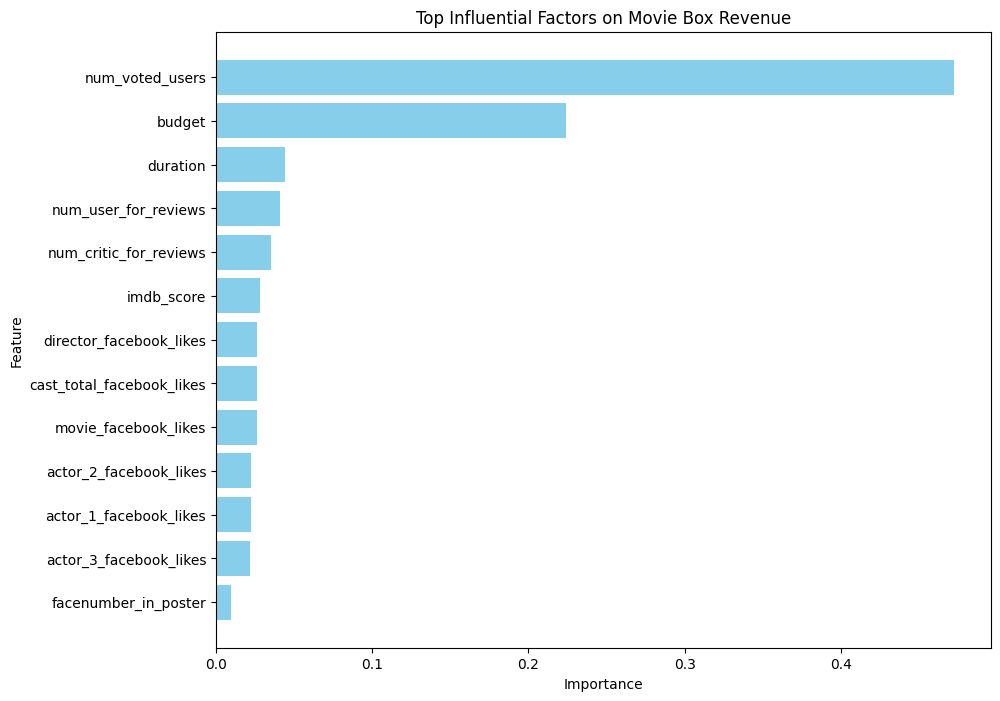

In [116]:
# Feature importance
feature_importances = model.feature_importances_
features_importance_mov = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
features_importance_mov = features_importance_mov.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 8))
plt.barh(features_importance_mov['Feature'], features_importance_mov['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Influential Factors on Movie Box Revenue')
plt.gca().invert_yaxis()
plt.show()

In [121]:
# STEP 3.4 RANDOM FOREST MODEL accounting both numerical and categorical features
# Remove 'profit' column from our data
movies_rf = movie_data.drop('profit', axis=1)

# Selecting independable features and target
features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
            'actor_3_facebook_likes', 'director_facebook_likes',
            'duration', 'num_critic_for_reviews', 'num_user_for_reviews',
            'num_voted_users', 'cast_total_facebook_likes',
            'facenumber_in_poster', 'movie_facebook_likes',
            'imdb_score', 'genres', 'content_rating', 'language']

X = movies_rf[features]
y = movies_rf['gross']

# One-hot encoding categorical columns using pd.get_dummies()
X = pd.get_dummies(X, columns=['genres', 'content_rating', 'language'], drop_first=True)

# Standard Scaling for numerical columns
numerical_features = ['budget', 'actor_1_facebook_likes', 'actor_2_facebook_likes',
                      'actor_3_facebook_likes', 'director_facebook_likes', 'duration',
                      'num_critic_for_reviews', 'num_user_for_reviews', 'num_voted_users',
                      'cast_total_facebook_likes', 'facenumber_in_poster', 'movie_facebook_likes', 'imdb_score']

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Building the Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 1574885810677000.0
R^2 Score: 0.6926562211162473


In [ ]:
# The Random Forest Model that accounts both categorical and scaled numeric features
# has the highest accuracy rates as R² score is higher (69%) and MSE is lower.
# 12% improvement in accuracy rate comparing to the initial Multi Linear Regression model

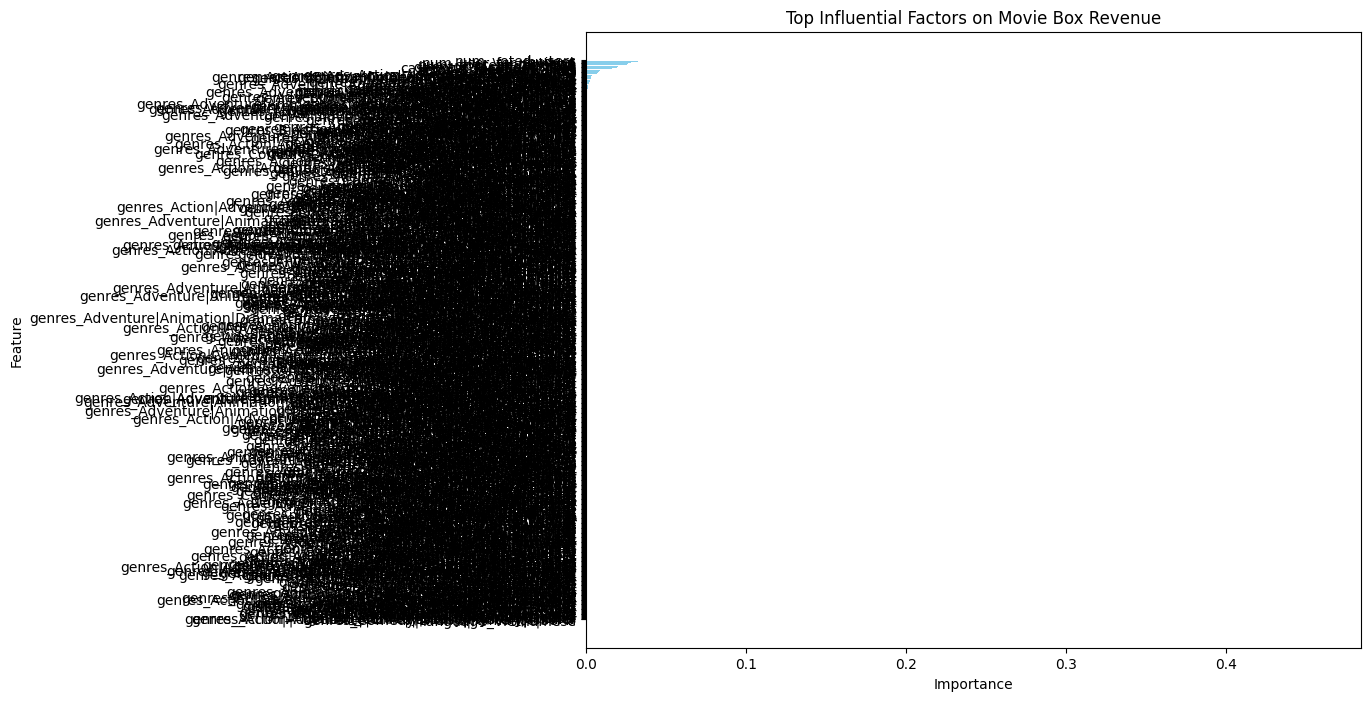

In [122]:
# Extracting feature importance, Random Forest with categorical and numerical values:
importances = model.feature_importances_
all_feature_names = X.columns

# Creating DataFrame for feature importances
features_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
features_importance_df = features_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importance
plt.figure(figsize=(10, 8))
plt.barh(features_importance_df['Feature'], features_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Influential Factors on Movie Box Revenue')
plt.gca().invert_yaxis()
plt.show()

In [123]:
# STEP 3.5 RANDOM FOREST MODEL adjusted
# Remove 'profit' column from our data
movies_adj = movie_data.drop('profit', axis=1)

In [130]:
# Calculate the frequency of each unique budget value to implement binnning
budget_type_counts = movies_rf['budget'].value_counts()

# Determine the threshold for binning (5% of the total number of rows)
threshold = 0.05 * len(movies_rf)

# Identify the budget values that occur less frequently than the threshold
rare_budget_values = budget_type_counts[budget_type_counts < threshold].index

# Replace rare budget values with a common category, e.g., 'other'
movies_rf['budget_binned'] = movies_rf['budget'].apply(lambda x: 'other' if x in rare_budget_values else x)

# Check the transformation
print(movies_rf['budget_binned'].value_counts())


budget_binned
other    2828
Name: count, dtype: int64


In [126]:
# Combine rare categories in 'genres' based on frequency
genres_type_counts = movies_rf['genres'].value_counts()
rare_genres = genres_type_counts[genres_type_counts < threshold].index

# Replace rare genres with 'other'
movies_rf['genres_binned'] = movies_rf['genres'].apply(lambda x: 'other' if x in rare_genres else x)

# One-hot encode the binned 'genres' column
X = pd.get_dummies(movies_rf, columns=['genres_binned', 'content_rating', 'language'], drop_first=True)

In [127]:
# Remove outliers based on Z-score
from scipy import stats

# Define the threshold for Z-score
z_threshold = 3

# Remove rows with outliers in 'budget' and 'gross'
movies_rf = movies_rf[(np.abs(stats.zscore(movies_rf[['budget', 'gross']])) < z_threshold).all(axis=1)]

In [131]:
# Create a new feature 'budget per vote'
movies_rf['budget_per_vote'] = movies_rf['budget'] / (movies_rf['num_voted_users'] + 1)  # +1 to avoid division by zero

# Make sure to fill any NaN values that may result
movies_rf['budget_per_vote'] = movies_rf['budget_per_vote'].fillna(movies_rf['budget_per_vote'].mean())

In [132]:
# Retrain the model using only the top 10 features (from the initial feature importance analysis)
top_features = features_importance_df.head(10)['Feature'].tolist()
X_top = X[top_features]

# Train-test split and scaling as before
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the Random Forest model with selected features
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error after feature selection: {mse}')
print(f'R^2 Score after feature selection: {r2}')

Mean Squared Error after feature selection: 1596242283458208.0
R^2 Score after feature selection: 0.6884884401865411


In [ ]:
# Implementing feature engineering like binning and creating new features very sligthly decreased our accuracy rates.

In [135]:
# STEP 3.6 RANDOM FOREST MODEL using classes
# Create a copy
movies_classes = movie_data.copy()

In [136]:
# Calculate Profit Margin (%) and create a new column
movies_classes['profit_margin'] = (movies_classes['profit'] / movies_classes['gross']) * 100

# Define the function to classify movies based on Profit Margin
def classify_profit_margin(margin):
    if margin > 50:
        return 'Highly Profitable'
    elif 20 < margin <= 50:
        return 'Moderately Profitable'
    elif 0 < margin <= 20:
        return 'Marginally Profitable'
    elif margin == 0:
        return 'Break-even'
    else:
        return 'Unprofitable'

# Apply the function to create the 'profit_category' column
movies_classes['profit_category'] = movies_classes['profit_margin'].apply(classify_profit_margin)

# Display the new columns
print(movies_classes[['profit_margin', 'profit_category']].head())


   profit_margin        profit_category
0      68.836532      Highly Profitable
1       3.039439  Marginally Profitable
2      44.212697  Moderately Profitable
3    -260.942743           Unprofitable
4      23.335284  Moderately Profitable


In [139]:
# Prepare the Data for the Random Forest Model

# Selecting features ('budget', 'gross', and 'profit' were excluded to avoid biases)
features = ['actor_1_facebook_likes', 'actor_2_facebook_likes',
            'actor_3_facebook_likes', 'director_facebook_likes',
            'duration', 'num_critic_for_reviews', 'num_user_for_reviews',
            'num_voted_users', 'cast_total_facebook_likes',
            'facenumber_in_poster', 'movie_facebook_likes',
            'imdb_score', 'genres', 'content_rating', 'language']

# Defining independent features and target variable
X = movies_classes[features]
y = movies_classes['profit_category']

# Encode categorical columns using pd.get_dummies()
X = pd.get_dummies(X, columns=['genres', 'content_rating', 'language'], drop_first=True)

# Standard Scaling for numerical columns
numerical_features = ['actor_1_facebook_likes', 'actor_2_facebook_likes', 'actor_3_facebook_likes',
                      'director_facebook_likes', 'duration', 'num_critic_for_reviews',
                      'num_user_for_reviews', 'num_voted_users', 'cast_total_facebook_likes',
                      'facenumber_in_poster', 'movie_facebook_likes', 'imdb_score']

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Building the Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Model evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print('\nClassification Report:')
print(classification_report(y_test, y_pred))
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.533106960950764

Classification Report:
                       precision    recall  f1-score   support

    Highly Profitable       0.54      0.54      0.54       184
Marginally Profitable       0.33      0.02      0.04        52
Moderately Profitable       0.33      0.07      0.11       103
         Unprofitable       0.54      0.82      0.65       250

             accuracy                           0.53       589
            macro avg       0.44      0.36      0.34       589
         weighted avg       0.49      0.53      0.47       589


Confusion Matrix:
[[100   1   6  77]
 [ 14   1   2  35]
 [ 34   0   7  62]
 [ 37   1   6 206]]


In [145]:
# The Randmom Forest model accounting bit categorical and scaled numerical features
# without any feature engineering or using classes so far has the highest accuracy rate of %69.

# STEP 3.7 RANDOM FOREST MODEL Hyperparameter Tuning
# Remove 'profit' column from our data
movies_ht = movie_data.drop('profit', axis=1)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Set the model
model = RandomForestClassifier()

# Set up the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy'
grid_search.fit(X_train, y_train)

# Find best parameters
best_params = grid_search.best_params_
print("Best Parmeters:", best_params)





